# Cusp-capturing PINN - Example 7

* level set augmentation: $\phi_a = |\phi|$

### Import packages

In [1]:
import torch
import torch.nn as nn
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import functools
from pyDOE import lhs

from functorch import make_functional, vmap, grad, jacrev, hessian

from collections import namedtuple, OrderedDict
import datetime
import time
from IPython.display import clear_output 

import warnings
warnings.filterwarnings('ignore')

### Empty cache and check devices

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

device =  cpu


### Problem setup

In [3]:
# domain [a,b]\times[c,d]\times[e,f]
ba = - 1.
bb =   1.
bc = - 1.
bd =   1.
be = - 1.
bf =   1.
dstab = bb - ba
dstcd = bd - bc
dstef = bf - be
# interface info.
rd0 = 0.483
rdi = 0.151
rde = 0.911
bk = [0.1, -0.1, 0.15]
nk = [3, 4, 7]
tk = [0.5, 1.8, 0.]
# tolerence for LM
tol_main1   = 10**(-16)
tol_main2   = 5*10**(-16)
tol_machine = 10**(-16)
mu_max      = 10**8
mu_ini      = 10**8
mu_mul      = 2.
mu_div      = 1.2
# iteration counts and check
tr_iter_max    = 3000                      # max. iteration
ts_input_new   = 500                       # renew testing points 
ls_check       = 500
ls_check0      = ls_check - 1
# number of testing points
N_tsd_final = 500000
N_tsb_final = 100000
N_tsg_final = 10000
# create names for loading meshes
Xg_name_tst = 'Xg_4490.txt'
Xbi_name_tst = 'Xbi_358.txt'
Xbo_name_tst = 'Xbo_5464.txt'

### Exact solution, beta, source, and level set function

In [4]:
def levfun(x, y, z):  # phi = f - r0*( 1 + g*h )
    # pieces for level function
    dsq0 = x*x + y*y
    zsq  = z*z
    dsq  = dsq0 + zsq
    thet = np.arctan2(y, x)
    gcf  = 4*dsq0/(dsq**3)
    bn0  = bk[0]*nk[0]
    bn1  = bk[1]*nk[1]
    bn2  = bk[2]*nk[2]
    cth0 = np.cos( nk[0]*(thet-tk[0]) )  
    cth1 = np.cos( nk[1]*(thet-tk[1]) )  
    cth2 = np.cos( nk[2]*(thet-tk[2]) )
    sth0 = np.sin( nk[0]*(thet-tk[0]) )  
    sth1 = np.sin( nk[1]*(thet-tk[1]) )  
    sth2 = np.sin( nk[2]*(thet-tk[2]) )
    tgrad = np.hstack( ( -y , x , np.zeros_like(z) ) )/dsq0    
    # f(p) related
    fp = np.sqrt(dsq)
    fgrad = np.hstack( ( x , y , z ) )/fp
    flap  = 2./fp
    # g(p)
    gp = (dsq0/dsq)**2
    ggrad = gcf*np.hstack( ( x*zsq , y*zsq , -dsq0*z ) )
    glap  = gcf*( 4*zsq - dsq0 )
    # h(p)
    hp = bk[0]*cth0 + bk[1]*cth1 + bk[2]*cth2
    hgrad = - ( bn0*sth0 + bn1*sth1 + bn2*sth2 ) * tgrad
    hlap  = - ( bn0*nk[0]*cth0 + bn1*nk[1]*cth1 + bn2*nk[2]*cth2 )/dsq0
    # phi0
    qo = fp - rd0*( 1 + gp*hp )
    # ggrad dot hgrad
    ggrad_dot_hgrad = np.sum( ggrad*hgrad , axis=1 ).reshape( (len(qo),1) )
    # phi related
    phigrad = fgrad - rd0*( gp*hgrad + ggrad*hp )
    philap  = flap - rd0*( gp*hlap + glap*hp + 2*ggrad_dot_hgrad )
    # output
    q = np.zeros( (len(x),11) )
    q[:,0:1] = qo
    q[:,1:4] = phigrad
    q[:,4:5] = philap
    for i in range(len(x)):
        if qo[i] < 0.:
            q[i,0:5] = - q[i,0:5]
    q[:,5:6]   = np.sum( q[:,1:4]**2 , axis=1 ).reshape( (len(x),1) )
    q[:,6:10]  = exact_mu(x, y, z, qo)
    q[:,10:11] = np.sum( q[:,7:10]*q[:,1:4] , axis=1 ).reshape( (len(x),1) )
    return qo, q


def exact_mu(x, y, z, qo):
    emu = np.zeros( (len(qo),4) )
    pm4 = 4*np.pi
    for i in range(len(qo)):
        if qo[i] < 0.:
            tx = pm4*x[i]
            ty = pm4*y[i]
            ctx = np.cos(tx)
            cty = np.cos(ty)
            stx = np.sin(tx)
            sty = np.sin(ty)
            cz  = np.cos(z[i])
            sz  = np.sin(z[i])
            emu[i,0:1] = 10 + ( stx - sty )*cz
            emu[i,1:2] =   pm4*ctx*cz
            emu[i,2:3] = - pm4*cty*cz
            emu[i,3:4] = - ( stx - sty )*sz 
        else:
            emu[i,0:1] = 1.
    return emu


def lvnorvec(x, y, z):  
    # pieces for level function
    dsq0 = x*x + y*y
    zsq  = z*z
    dsq  = dsq0 + zsq
    thet = np.arctan2(y, x)
    gcf  = 4*dsq0/(dsq**3)
    bn0  = bk[0]*nk[0]
    bn1  = bk[1]*nk[1]
    bn2  = bk[2]*nk[2]
    cth0 = np.cos( nk[0]*(thet-tk[0]) )  
    cth1 = np.cos( nk[1]*(thet-tk[1]) )  
    cth2 = np.cos( nk[2]*(thet-tk[2]) )
    sth0 = np.sin( nk[0]*(thet-tk[0]) )  
    sth1 = np.sin( nk[1]*(thet-tk[1]) )  
    sth2 = np.sin( nk[2]*(thet-tk[2]) )
    tgrad = np.hstack( ( -y , x , np.zeros_like(z) ) )/dsq0    
    # f(p) related
    fp = np.sqrt(dsq)
    fgrad = np.hstack( ( x , y , z ) )/fp
    # g(p)
    gp = (dsq0/dsq)**2
    ggrad = gcf*np.hstack( ( x*zsq , y*zsq , -dsq0*z ) )
    # h(p)
    hp = bk[0]*cth0 + bk[1]*cth1 + bk[2]*cth2
    hgrad = - ( bn0*sth0 + bn1*sth1 + bn2*sth2 ) * tgrad
    # phi related
    phigrad = fgrad - rd0*( gp*hgrad + ggrad*hp )
    # output
    dqsqrt = np.sqrt( np.sum(phigrad**2,axis=1).reshape((len(x),1)) )
    norvec = phigrad/dqsqrt
    return norvec, dqsqrt


# exact solution
def exact_u(x, y, z, qo): 
    eu = np.zeros_like(qo)
    # example 01
    for i in range(len(qo)):
        if qo[i] < 0.:
            eu[i] = np.sin(2*x[i])*np.cos(2*y[i])*np.exp(z[i])
        else:
            tp   = (y[i]-x[i])/3.
            tpsq = tp*tp
            f    = ( (16*tpsq-20)*tpsq + 5 )*tp
            g    = np.log( x[i] + y[i] + 3 )
            h    = np.cos( z[i] )
            eu[i] = f*g*h
    return eu


def exact_ugrad_ulap(x, y, z, qo): 
    ugrad = np.zeros((len(qo),3))
    ulap  = np.zeros((len(qo),1))
    # example 01
    for i in range(len(qo)):
        if qo[i] < 0.:
            c2x = np.cos(2*x[i])
            c2y = np.cos(2*y[i])
            s2x = np.sin(2*x[i])
            s2y = np.sin(2*y[i])
            ez  = np.exp(z[i])
            ugrad[i,0:1] =   c2x*c2y*ez*2
            ugrad[i,1:2] = - s2x*s2y*ez*2
            ugrad[i,2:3] =   s2x*c2y*ez
            ulap[i,0:1]  = - s2x*c2y*ez*7
        else:
            tp   = (y[i]-x[i])/3.
            tpsq = tp*tp
            f    = ( (16*tpsq-20)*tpsq + 5 )*tp
            df   = - ( (80*tpsq-60)*tpsq + 5 )/3.    # with respect to x
            ddf  = ( 320*tpsq - 120 )*tp/9.        # with respect to x
            g    = np.log( x[i] + y[i] + 3 )
            dg   = 1./( x[i] + y[i] + 3. )
            ddg  = - dg*dg
            h    =   np.cos(z[i])
            dh   = - np.sin(z[i])
            ugrad[i,0:1] = ( f*dg + df*g  ) * h
            ugrad[i,1:2] = ( f*dg - df*g  ) * h
            ugrad[i,2:3] = f * g * dh
            ulap[i,0:1]  = ( 2*(f*ddg+ddf*g) - f*g ) * h 
    return ugrad, ulap


# jump of u calong interface: [u]=gamma 
def jump_u(x, y, z): 
    qo = np.ones_like(z) 
    # jump of u
    uo = exact_u(x, y, z,  qo)
    ui = exact_u(x, y, z, -qo)
    u_jp = uo - ui
    return u_jp

 
# normal derivative jump condition along interface: [\mu\partial_n u]=rho 
def jump_flux(x, y, z):  
    # level function info at interface
    norvec, dqnorm = lvnorvec(x, y, z)
    # beta at interface (INCLUDE GRADIENT OF MU)
    q = np.ones_like(x)
    mup = exact_mu(x, y, z,  q)
    mup0 = mup[:,0:1]
    mun = exact_mu(x, y, z, -q)
    mun0 = mun[:,0:1]
    # grad u
    ugradp, tmp = exact_ugrad_ulap(x, y, z,  q)
    ugradn, tmp = exact_ugrad_ulap(x, y, z, -q)
    # jump of mu*du/dn
    unp = np.sum( ugradp*norvec , axis=1 ).reshape( (len(q),1) )
    unn = np.sum( ugradn*norvec , axis=1 ).reshape( (len(q),1) )
    flux_jp = mup0*unp - mun0*unn
    mu_jp   = mup0 - mun0
    muspgd  = (mup0+mun0)*dqnorm
    return flux_jp, norvec, mu_jp, muspgd


# source
def exact_rhsu(x, y, z, qo): 
    # exact solution u and mu
    emu = exact_mu(x, y, z, qo)
    #eu  = exact_u(x, y, z, qo)
    ugrad, ulap = exact_ugrad_ulap(x, y, z, qo)
    ef  = emu[:,0:1]*ulap + np.sum(emu[:,1:4]*ugrad,axis=1).reshape((len(qo),1))            
    return ef

### Define network: Shallow or Deep

In [5]:
class NeuralNet_Shallow(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    
    def __init__(self, in_dim , h_dim , out_dim):
        super(NeuralNet_Shallow, self).__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        #self.act1 =nn.Tanh()
        #self.act1 =nn.ReLU()
        
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out

In [6]:
class NeuralNet_Deep(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    ### depth: depth of the network
    def __init__(self, in_dim , h_dim , out_dim , depth ):
        super(NeuralNet_Deep, self).__init__()
        self.depth = depth - 1
        self.list  = nn.ModuleList()
        self.ln1   = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        #self.act1  = nn.Tanh()
        
        for i in range(self.depth):
            self.list.append( nn.Linear( h_dim , h_dim ) )
        
        self.lnd = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        for i in range(self.depth):
            out = self.list[i](out)
            out = self.act1(out)
        out = self.lnd(out)
        return out

### Essential nametuples in the model

In [7]:
DataInput_v = namedtuple( "DataInput_v" , [ "Xg" , "Fg" , "NL" , "NL_sqrt"] )
DataInput_w = namedtuple( "DataInput_w" , [ "Xd" , "Fd" , "Xb" , "Fb" , "Xg" , "Fg" , "NL" , "NL_sqrt"] )
LM_Setup  = namedtuple( "LM_Setup" , [ 'p_vec_o' , 'dp_o' , 'L_o' , 'J_o' , 'mu0' , 'criterion' ] )

### Data generator

In [8]:
def generate_data_v(Ng):   
    ## X_gma: points on the interface N_trg
    Xg = np.loadtxt(Xg_name_tr, dtype='float64')
    # jump condition for u
    Fg = jump_u(Xg[:,0:1], Xg[:,1:2], Xg[:,2:3])  
    # size of each piece of loss
    Ng_new  = len(Xg[:,0:1])
    NL      = [Ng_new, Ng_new]
    NL_sqrt = np.sqrt(NL)
    # torch tensor
    Xg = torch.tensor(Xg, requires_grad=True).double().to(device)
    Fg = torch.tensor(Fg).double().to(device)
    return Xg, Fg, NL, NL_sqrt 



def generate_data_w(iopt, Nd, Nb, Ng):
    ## Xd: points inside the domain (randomly)
    sampling = lhs(3, Nd)
    xd = ba + dstab*sampling[:,0:1]
    yd = bc + dstcd*sampling[:,1:2]
    zd = be + dstef*sampling[:,2:3]   
    # remove pts out of domain
    dst = np.sqrt(xd*xd+yd*yd+zd*zd)
    dstid = np.where(dst>=rde)
    dst = np.delete(dst, dstid[0], 0)
    xd  = np.delete(xd, dstid[0], 0)
    yd  = np.delete(yd, dstid[0], 0)
    zd  = np.delete(zd, dstid[0], 0)
    dstid = np.where(dst<=rdi)
    dst = np.delete(dst, dstid[0], 0)
    xd  = np.delete(xd, dstid[0], 0)
    yd  = np.delete(yd, dstid[0], 0)
    zd  = np.delete(zd, dstid[0], 0)
    qdo, qd = levfun(xd, yd, zd)
    # remove points at the interface
    qid = np.where(np.abs(qdo)<5e-16)
    qdo = np.delete(qdo, qid[0], 0)
    qd  = np.delete(qd, qid[0], 0)
    xd  = np.delete(xd, qid[0], 0)
    yd  = np.delete(yd, qid[0], 0)
    zd  = np.delete(zd, qid[0], 0) 
    Nd_new = len(qdo)
    # torch tensor and requires_grad
    Xd = np.hstack( ( xd , yd , zd , qd[:,0:1] ) )
    fd = exact_rhsu(xd, yd, zd, qdo)
    Fd = np.hstack( ( fd , qd[:,1:] ) )
    
    ## Xb: points at the boundary
    Xbi = np.loadtxt(Xbi_name_tr, dtype='float64')
    Vbi = func_model_v( func_params_v, torch.tensor(Xbi).double().to(device) ).detach().cpu().numpy()
    Nbi_tr = len(Vbi)
    # outer boundary
    Xbo = np.loadtxt(Xbo_name_tr, dtype='float64')
    Nbo_tr = len(Xbo[:,0:1])
    # combine
    Xb  = np.vstack( ( Xbi , Xbo ) )
    Nb_new = Nbi_tr + Nbo_tr
    qbo, qb = levfun(Xb[:,0:1], Xb[:,1:2], Xb[:,2:3])
    Xb  = np.hstack( ( Xb , qb[:,0:1] ) )
    # Boundary condition
    Fb = exact_u(Xb[:,0:1], Xb[:,1:2], Xb[:,2:3], qbo)
    Fb[0:Nbi_tr,0:1] -= Vbi   # remove V at the inner boundary for boundary condition of w 
    
    ## X_gma: points on the interface N_trg
    Xg = np.loadtxt(Xg_name_tr, dtype='float64')
    xg = Xg[:,0:1]
    yg = Xg[:,1:2]
    zg = Xg[:,2:3]
    Ng_new = len(xg)
    Xg = np.hstack( ( Xg , np.zeros((Ng_new,1)) ) )
    # normal derivative jump condition for level function
    flux_jp, norvec, mu_jp, muspgd = jump_flux(xg, yg, zg)
    # combine all sources
    Fg = np.hstack( ( flux_jp , norvec , mu_jp , muspgd ) )
    
    # size of each piece of loss
    NL      = [Nd_new+Nb_new+Ng_new, Nd_new, Nb_new, Ng_new]
    NL_sqrt = np.sqrt(NL)

    ## plot the distribution of data
    if iopt != 0:
        print(f'No. of training points in the bulk domain: {Nd_new}')
        print(f'No. of training points at the outer boundary: {Nb_new}')
        print(f'No. of training points at the interface: {Ng_new}') 
        print(f'No. of total training points: {Nd_new + Nb_new + Ng_new}') 
        fig = plt.figure(figsize = (10,10))
        ax = plt.axes(projection='3d')
        ax.scatter3D(Xd[:,0], Xd[:,1], Xd[:,2], c = "b", marker = ".") 
        ax.scatter3D(Xb[:,0], Xb[:,1], Xb[:,2], c = "r", marker = ".")
        ax.scatter3D(Xg[:,0], Xg[:,1], Xg[:,2], c = "k", marker = ".")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('training points')
        ax.view_init(elev=30, azim=-30)
        plt.show()
        
    # torch tensor
    Xd = torch.tensor(Xd, requires_grad=True).double().to(device)
    Fd = torch.tensor(Fd).double().to(device)
    Xb = torch.tensor(Xb, requires_grad=True).double().to(device)
    Fb = torch.tensor(Fb).double().to(device)
    Xg = torch.tensor(Xg, requires_grad=True).double().to(device)
    Fg = torch.tensor(Fg).double().to(device)

    # modification of flux condition
    Xgv = torch.tensor( np.hstack( (xg,yg,zg) ) , requires_grad=True ).double().to(device)
    mug = exact_mu(xg, yg, zg, -np.ones_like(xg))
    Fgv = torch.tensor( np.hstack( (mug[:,0:1],norvec) ) ).double().to(device)
    Vdn = vmap(func_pred_vdn, (None, 0, 0))(func_params_v, Xgv, Fgv).reshape((Ng_new,1))
    Fg[:,0:1] += Vdn
    
    # modify right hand side 
    Vlap = vmap(func_pred_vlap, (None, 0, 0))(func_params_v, Xd[:,0:3], Fd[:,6:10])
    for i in range(Nd_new):
        if ( qdo[i]<0. ):
            Fd[i,0:1] -= Vlap[i]
    
    return Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt 

### Components of loss

In [9]:
# compute the interior loss
def func_lossd_w(func_params, pts, fd):
    def f(x, func_params):
        fx = func_model_w(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u wrt inputs
    
    d1u = jacrev(f)(pts, func_params)
    d2u = jacrev(jacrev(f))(pts, func_params)
    
    w_x  = d1u[0]
    w_y  = d1u[1]
    w_z  = d1u[2]
    w_p  = d1u[3]
    w_pp = d2u[3][3]
    w_xx = d2u[0][0]
    w_xp = d2u[0][3] 
    w_yy = d2u[1][1]
    w_yp = d2u[1][3]
    w_zz = d2u[2][2]
    w_zp = d2u[2][3]
    lossd = fd[6] * ( w_xx+w_yy+w_zz + 2.*(w_xp*fd[1]+w_yp*fd[2]+w_zp*fd[3]) + w_p*fd[4] + w_pp*fd[5] ) \
            + fd[7]*w_x + fd[8]*w_y + fd[9]*w_z + w_p*fd[10] - fd[0]
    return lossd/pnt_fd


# compute the boundary loss 
def func_lossb_w(func_params, pts, fb):
    def f(x, func_params):
        fx = func_model_w(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # function value at the boundary (Dirichlet boundary condition)
    lossb = f(pts, func_params) - fb
    return lossb/pnt_fb


# compute the interfacial loss
def func_lossg_w(func_params, pts, fg):
    def f(x, func_params):
        fx = func_model_w(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u wrt inputs
    
    d1u = jacrev(f)(pts, func_params)
    
    wg_x = d1u[0]
    wg_y = d1u[1]
    wg_z = d1u[2]
    wg_p = d1u[3]
    lossg = fg[4]*(wg_x*fg[1]+wg_y*fg[2]+wg_z*fg[3]) + wg_p*fg[5] - fg[0]
    return lossg/pnt_fg


# compute the intercial loss
def func_lossg_v(func_params, pts, fg):
    def f(x, func_params):
        fx = func_model_v(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # v at interface
    lossg = f(pts, func_params) + fg[0]
    return lossg

def func_pred_vdn(func_params, pts, fg):
    def f(x, func_params):
        fx = func_model_v(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # v and derivatives of f wrt inputs
    
    d1u = jacrev(f)(pts, func_params)
    
    v_x = d1u[0]
    v_y = d1u[1]
    v_z = d1u[2]
    vdn = fg[0] * ( v_x*fg[1] + v_y*fg[2] + v_z*fg[3] )
    return vdn

def func_pred_vlap(func_params, pts, fd):
    def f(x, func_params):
        fx = func_model_v(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # v and derivatives of f wrt inputs
    
    d1u = jacrev(f)(pts, func_params)
    d2u = jacrev(jacrev(f))(pts, func_params)
    
    v_x  = d1u[0]
    v_y  = d1u[1]
    v_z  = d1u[2]
    v_xx = d2u[0][0]
    v_yy = d2u[1][1]
    v_zz = d2u[2][2]
    vlap = fd[0]*(v_xx+v_yy+v_zz) + fd[1]*v_x + fd[2]*v_y + fd[3]*v_z
    return vlap

### Levenberg-Marquardt (LM) optimizer

In [10]:
# parameters counter
def count_parameters(func_params):
    return sum(p.numel() for p in func_params if p.requires_grad)

In [11]:
# get the model's parameter
def get_p_vec(func_params):
    p_vec = []
    cnt = 0
    for p in func_params:
        p_vec = p.contiguous().view(-1) if cnt == 0 else torch.cat([p_vec, p.contiguous().view(-1)])
        cnt = 1 
    return p_vec

In [12]:
# Initialization of LM method
def generate_initial_LM(func_params, data_length):
    
    # p_vector
    with torch.no_grad():
        p_vec_old = get_p_vec(func_params).double().to(device)
    
    # dp
    dp_old = torch.zeros( [ count_parameters(func_params) , 1 ] ).double().to(device)

    # Loss
    L_old = torch.zeros( [ data_length , 1 ] ).double().to(device)
    
    # Jacobian
    J_old = torch.zeros( [ data_length , count_parameters(func_params) ] ).double().to(device)
    
    return p_vec_old, dp_old, L_old, J_old

In [13]:
def train_PINNs_v_LM(func_params, LM_setup, tr_input, lossval):
    
    # assign tuple elements of LM_set_up
    p_vec_o, dp_o, L_o, J_o, mu, criterion = LM_setup
    I_pvec = torch.eye(len(p_vec_o)).to(device)
    
    # assign tuple elements of data_input 
    [Xg, Fg, NL, NL_sqrt] = tr_input
    
    # iteration counts and check
    Comput_old = True
    step       = 0
    
    # try-except statement to avoid jam in the code
    try:
        while (lossval[-1]>0.01*tol_main2) and (step<=tr_iter_max):
            
            torch.cuda.empty_cache()
            
            ############################################################
            # LM_optimizer
            if ( Comput_old == True ):   # need to compute loss_old and J_old
                
                ### computation of loss
                Lg = vmap((func_lossg_v), (None, 0, 0))(func_params, Xg, Fg).flatten().detach()
                L = Lg/NL_sqrt[1]
                L = L.reshape(NL[0],1)
                lsg_sum = torch.sum(Lg*Lg)/NL[1]
                
            loss_old     = lossval[-1]
            
            ### compute the gradinet of loss function for each point
            with torch.no_grad():
                p_vec = get_p_vec(func_params).detach() # get p_vec for p_vec_old if neccessary 
        
            if criterion:
                per_grad = vmap(jacrev(func_lossg_v), (None, 0, 0))(func_params, Xg, Fg)
                cnt = 0
                for g in per_grad: 
                    g = g.detach()
                    J_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_g,g.reshape(len(g),-1)])
                    cnt = 1
            
                J = J_g/NL_sqrt[1]
                
                ### info. normal equation of J
                J_product = J.t()@J
                rhs       = - J.t()@L
                 
                    
            with torch.no_grad():
                ### solve the linear system
                dp  = torch.linalg.solve( J_product + mu*I_pvec , rhs )
                cnt = 0
                for p in func_params:
                    mm   = torch.Tensor([p.shape]).tolist()[0]
                    num  = int( functools.reduce( lambda x,y : x*y, mm, 1 ) )
                    p   += dp[cnt:cnt+num].reshape(p.shape)
                    cnt += num
            
            ### Compute loss_new    
            Lg = vmap((func_lossg_v), (None, 0, 0))(func_params, Xg, Fg).flatten().detach()
            L = Lg/NL_sqrt[1]
            L = L.reshape( NL[0] , 1 )
            loss_new = torch.sum(L*L).item()
            lsg_sum  = torch.sum(Lg*Lg)/NL[1]

                
            # strategy to update mu
            if ( step > 0 ):
                
                with torch.no_grad():
             
                    # accept update 
                    if loss_new < loss_old:
                        p_vec_old  = p_vec.detach()
                        dp_old     = dp
                        L_old      = L
                        J_old      = J
                        mu         = max( mu/mu_div , tol_machine )
                        criterion  = True #False
                        Comput_old = False
                        lossval.append(loss_new)
                    
                    else:
                        cosine = nn.functional.cosine_similarity(dp, dp_old, dim=0, eps=1e-15)
                        cosine_check = (1.-cosine)*loss_new > min(lossval) # loss_old
                        if cosine_check: # give up the direction
                            cnt=0
                            for p in func_params:
                                mm   = torch.Tensor([p.shape]).tolist()[0]
                                num  = int( functools.reduce(lambda x,y: x*y, mm, 1) )
                                p   -= dp[cnt:cnt+num].reshape(p.shape)
                                cnt += num
                            mu = min( mu_mul*mu , mu_max )
                            criterion  = False
                            Comput_old = False
                        else: # accept 
                            p_vec_old = p_vec.detach()
                            dp_old    = dp 
                            L_old     = L
                            J_old     = J
                            mu        = max( mu/mu_div , tol_machine )       
                            criterion  = True
                            Comput_old = False
                        lossval.append(loss_old)
            
            else:   # for old info. 
       
                with torch.no_grad():
              
                    p_vec_old  = p_vec.detach()
                    dp_old     = dp
                    L_old      = L
                    J_old      = J
                    mu         = max( mu/mu_div , tol_machine )
                    criterion  = True
                    Comput_old = False
                    lossval.append(loss_new)
           
            
            if step % ls_check == ls_check0:
                print("Step %s: " % (step) )
                print(f" training loss: {lossval[-1]:.4e}")
                
            step += 1
                  
        print("Step %s: " % (step-1) )
        print(f" training loss: {lossval[-1]:.4e}")
        print('finished')
        lossval     = lossval[1:]
        return lossval
    
    except KeyboardInterrupt:
        print('Interrupt')
        print('steps = ', step)
        lossval     = lossval[1:]
        return lossval

In [14]:
def train_PINNs_w_LM(func_params, LM_setup, tr_input, lossval, lossval_dbg):
    
    # assign tuple elements of LM_set_up
    p_vec_o, dp_o, L_o, J_o, mu, criterion = LM_setup
    I_pvec = torch.eye(len(p_vec_o)).to(device)
    
    # assign tuple elements of data_input 
    [Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt] = tr_input
    
    # iteration counts and check
    Comput_old = True
    step       = 0
    
    # try-except statement to avoid jam in the code
    try:
        while (lossval[-1]>tol_main1) and (step<=tr_iter_max):
            
            torch.cuda.empty_cache()
            
            ############################################################
            # LM_optimizer
            if ( Comput_old == True ):   # need to compute loss_old and J_old
                
                ### computation of loss
                Ld = vmap((func_lossd_w), (None, 0, 0))(func_params, Xd, Fd).flatten().detach()
                Lb = vmap((func_lossb_w), (None, 0, 0))(func_params, Xb, Fb).flatten().detach()
                Lg = vmap((func_lossg_w), (None, 0, 0))(func_params, Xg, Fg).flatten().detach()
                L  = torch.cat( ( Ld/NL_sqrt[1] , Lb/NL_sqrt[2] , Lg/NL_sqrt[3] ) )
                L  = L.reshape(NL[0],1).detach()
                lsd_sum = torch.sum(Ld*Ld)/NL[1]
                lsb_sum = torch.sum(Lb*Lb)/NL[2]
                lsg_sum = torch.sum(Lg*Lg)/NL[3]
                loss_dbg_old = [lsd_sum.item(), lsb_sum.item(), lsg_sum.item()]
                        
            loss_old     = lossval[-1]
            loss_dbg_old = lossval_dbg[-1]
    
            ### compute the gradinet of loss function for each point
            with torch.no_grad():
                p_vec = get_p_vec(func_params).detach() # get p_vec for p_vec_old if neccessary 
        
            if criterion:
                per_sample_grads = vmap(jacrev(func_lossd_w), (None, 0, 0))(func_params, Xd, Fd)
                cnt = 0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1

                per_sample_grads = vmap(jacrev(func_lossb_w), (None, 0, 0))(func_params, Xb, Fb)
                cnt = 0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_b = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_b,g.reshape(len(g),-1)])
                    cnt = 1
        
                per_sample_grads = vmap(jacrev(func_lossg_w), (None, 0, 0))(func_params, Xg, Fg)
                cnt = 0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_g,g.reshape(len(g),-1)])
                    cnt = 1
            
                J = torch.cat( ( J_d/NL_sqrt[1] , J_b/NL_sqrt[2] , J_g/NL_sqrt[3] ) ).detach()
                
                ### info. normal equation of J
                J_product = J.t()@J
                rhs       = - J.t()@L
                 
                    
            with torch.no_grad():
                ### solve the linear system
                dp  = torch.linalg.solve( J_product + mu*I_pvec , rhs )
                cnt = 0
                for p in func_params:
                    mm   = torch.Tensor([p.shape]).tolist()[0]
                    num  = int( functools.reduce( lambda x,y : x*y, mm, 1 ) )
                    p   += dp[cnt:cnt+num].reshape(p.shape)
                    cnt += num
            
            ### Compute loss_new    
            Ld = vmap((func_lossd_w), (None, 0, 0))(func_params, Xd, Fd).flatten().detach()
            Lb = vmap((func_lossb_w), (None, 0, 0))(func_params, Xb, Fb).flatten().detach()
            Lg = vmap((func_lossg_w), (None, 0, 0))(func_params, Xg, Fg).flatten().detach()
            L  = torch.cat( ( Ld/NL_sqrt[1] , Lb/NL_sqrt[2] , Lg/NL_sqrt[3] ) )
            L  = L.reshape( NL[0] , 1 ).detach()
            loss_new = torch.sum(L*L).item()
            lsd_sum = torch.sum(Ld*Ld)/NL[1]
            lsb_sum = torch.sum(Lb*Lb)/NL[2]
            lsg_sum = torch.sum(Lg*Lg)/NL[3]
            loss_dbg_new = [lsd_sum.item(), lsb_sum.item(), lsg_sum.item()]
    
                
            # strategy to update mu
            if ( step > 0 ):
                
                with torch.no_grad():
             
                    # accept update 
                    if loss_new < loss_old:
                        p_vec_old  = p_vec.detach()
                        dp_old     = dp
                        L_old      = L
                        J_old      = J
                        mu         = max( mu/mu_div , tol_machine )
                        criterion  = True #False
                        Comput_old = False
                        lossval.append(loss_new)
                        lossval_dbg.append(loss_dbg_new)
                    
                    else:
                        cosine = nn.functional.cosine_similarity(dp, dp_old, dim=0, eps=1e-15)
                        cosine_check = (1.-cosine)*loss_new > min(lossval) # loss_old
                        if cosine_check: # give up the direction
                            cnt=0
                            for p in func_params:
                                mm   = torch.Tensor([p.shape]).tolist()[0]
                                num  = int( functools.reduce(lambda x,y: x*y, mm, 1) )
                                p   -= dp[cnt:cnt+num].reshape(p.shape)
                                cnt += num
                            mu = min( mu_mul*mu , mu_max )
                            criterion  = False
                            Comput_old = False
                        else: # accept 
                            p_vec_old = p_vec.detach()
                            dp_old    = dp 
                            L_old     = L
                            J_old     = J
                            mu        = max( mu/mu_div , tol_machine )       
                            criterion  = True
                            Comput_old = False
                        lossval.append(loss_old)
                        lossval_dbg.append(loss_dbg_old)
            
            else:   # for old info. 
       
                with torch.no_grad():
              
                    p_vec_old  = p_vec.detach()
                    dp_old     = dp
                    L_old      = L
                    J_old      = J
                    mu         = max( mu/mu_div , tol_machine )
                    criterion  = True
                    Comput_old = False
                    lossval.append(loss_new)
                    lossval_dbg.append(loss_dbg_new)
            
           
            if step % ls_check == ls_check0:
                print("Step %s: " % (step) )
                print(f" training loss: {lossval[-1]:.4e}")

            step += 1
                  
        print("Step %s: " % (step-1) )
        print(f" training loss: {lossval[-1]:.4e}")
        print('finished')
        lossval     = lossval[1:]
        lossval_dbg = lossval_dbg[1:]
        return lossval, lossval_dbg
    
    except KeyboardInterrupt:
        print('Interrupt')
        print('steps = ', step)
        lossval     = lossval[1:]
        lossval_dbg = lossval_dbg[1:]
        return lossval, lossval_dbg

### Main procedures

In [15]:
# load interfacial points
Xg_name_tr = 'Xg_752.txt'
# Network size
n_input0 = 3
n_input  = n_input0 + 1
n_hidden = 100
n_output = 1
n_depth = 1 # only used in deep NN
# number of training points and testing points
c_addpt = 1.
N_trg = 100

torch.cuda.empty_cache()
    
# NN structure
if n_depth == 1:   # Shallow NN
    model_v = NeuralNet_Shallow( n_input0 , n_hidden , n_output ).double().to(device)
else:   # Deep NN
    model_v = NeuralNet_Deep( n_input0 , n_hidden , n_output , n_depth ).double().to(device)

# use Pytorch and functorch
func_model_v, func_params_v = make_functional(model_v)
    
# generate training data
Xg_tr, Fg_tr, NL_tr, NL_sqrt_tr = generate_data_v(N_trg)
tr_input = DataInput_v(Xg=Xg_tr, Fg=Fg_tr, NL=NL_tr, NL_sqrt=NL_sqrt_tr)
        
# initialization of LM
p_vec_old, dp_old, L_old, J_old = generate_initial_LM(func_params_v, NL_tr[0])
print(f"No. of trainable parameters = {len(p_vec_old)}")
        
# LM_setup
mu = 10**(8)
criterion = True
LM_setup = LM_Setup( p_vec_o=p_vec_old , dp_o=dp_old , L_o=L_old , J_o=J_old , mu0=mu , criterion=criterion )

# allocate loss
lossval         = []
lossval.append(1.)

# train the model by LM optimizer
lossval = train_PINNs_v_LM(func_params_v, LM_setup, tr_input, lossval)

N_loss = len(lossval)
lossval        = np.array(lossval).reshape(N_loss,1)
epochcol = np.linspace(1, N_loss, N_loss).reshape(N_loss,1)

No. of trainable parameters = 500
Step 499: 
 training loss: 2.9439e-11
Step 999: 
 training loss: 1.9064e-14
Step 1499: 
 training loss: 1.6048e-15
Step 1999: 
 training loss: 5.9790e-16
Step 2499: 
 training loss: 5.9790e-16
Step 2999: 
 training loss: 2.9310e-16
Step 3000: 
 training loss: 2.9310e-16
finished


No. of training points in the bulk domain: 771
No. of training points at the outer boundary: 907
No. of training points at the interface: 752
No. of total training points: 2430


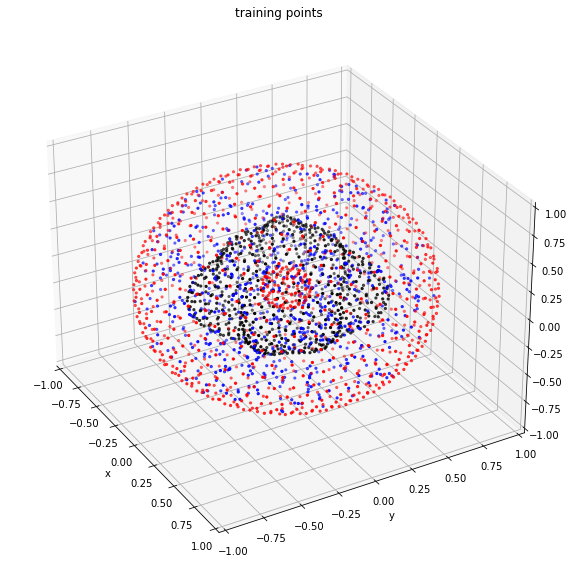

No. of trainable parameters = 600
Step 499: 
 training loss: 1.8773e-06
Step 999: 
 training loss: 2.1834e-10
Step 1499: 
 training loss: 2.1807e-11
Step 1999: 
 training loss: 2.1807e-11
Step 2499: 
 training loss: 1.9746e-11
Step 2999: 
 training loss: 1.9730e-11
Step 3000: 
 training loss: 1.9730e-11
finished


In [16]:
# fname
fname = 'test'
char_id = 'a'
# load interfacial points
Xbi_name_tr = 'Xbi_90.txt'
Xbo_name_tr = 'Xbo_817.txt'
# Network size
n_input0 = 3
n_input  = n_input0 + 1    # with augmented feature
n_hidden = 100
n_output = 1
n_depth = 1 # only used in deep NN
mu_div = 1.2
tr_iter_max = 3000
# number of training points and testing points
c_addpt = 1.
M0 = 30
N_trd = 2000 #M0*M0
N_trb = 200  #M0
N_trg = 2*M0

relerr_loss = []

for char in char_id:
    
    torch.cuda.empty_cache()
    
    # NN structure
    if n_depth == 1:   # Shallow NN
        model_w = NeuralNet_Shallow( n_input , n_hidden , n_output ).double().to(device)
    else:   # Deep NN
        model_w = NeuralNet_Deep( n_input , n_hidden , n_output , n_depth ).double().to(device)

    # use Pytorch and functorch
    func_model_w, func_params_w = make_functional(model_w)
    
    # generate training data
    Xd_tr, Fd_tr, Xb_tr, Fb_tr, Xg_tr, Fg_tr, NL_tr, NL_sqrt_tr = generate_data_w(1, N_trd, N_trb, N_trg)
    tr_input = DataInput_w(Xd=Xd_tr, Fd=Fd_tr, Xb=Xb_tr, Fb=Fb_tr, Xg=Xg_tr, Fg=Fg_tr, NL=NL_tr, NL_sqrt=NL_sqrt_tr)
    pnt_fd = torch.sqrt( torch.sum(Fd_tr[:,-1]*Fd_tr[:,-1])/NL_tr[1] )
    pnt_fb = torch.sqrt( torch.sum(Fb_tr*Fb_tr)/NL_tr[2] )
    pnt_fg = torch.sqrt( torch.sum(Fg_tr[:,0]*Fg_tr[:,0])/NL_tr[3] )
    
    # initialization of LM
    p_vec_old, dp_old, L_old, J_old = generate_initial_LM(func_params_w, NL_tr[0])
    print(f"No. of trainable parameters = {len(p_vec_old)}")
    
    # LM_setup
    mu = 10**(8)
    criterion = True
    LM_setup = LM_Setup( p_vec_o=p_vec_old , dp_o=dp_old , L_o=L_old , J_o=J_old , mu0=mu , criterion=criterion )

    # allocate loss
    lossval         = []
    lossval_dbg     = []
    lossval.append(1.)
    lossval_dbg.append([1.,1.,1.])

    # train the model by LM optimizer
    lossval, lossval_dbg = train_PINNs_w_LM(func_params_w, LM_setup, tr_input, lossval, lossval_dbg)
    
    N_loss = len(lossval)
    lossval        = np.array(lossval).reshape(N_loss,1)
    lossval_dbg    = np.array(lossval_dbg)
    epochcol = np.linspace(1, N_loss, N_loss).reshape(N_loss,1)

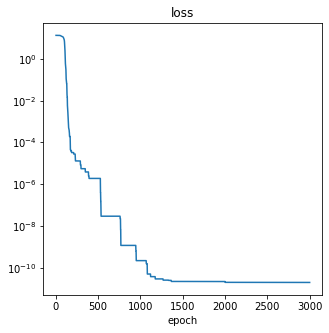

In [17]:
# plot evolution of loss
N_loss = len(lossval)
lossval        = np.array(lossval).reshape(N_loss,1)
epochcol = np.linspace(1, N_loss, N_loss).reshape(N_loss,1)

plt.figure(figsize = (5,5))

plt.semilogy(epochcol, lossval)
plt.title('loss')
plt.xlabel('epoch')
plt.show()

### Test data set 

No. of interior  test data point: N_tsd_final = 197128
No. of boundary  test data point: N_tsb_final = 5822
No. of interface test data point: N_tsg_final = 4490
No. of overall   test data point: N_ts_total  = 207440


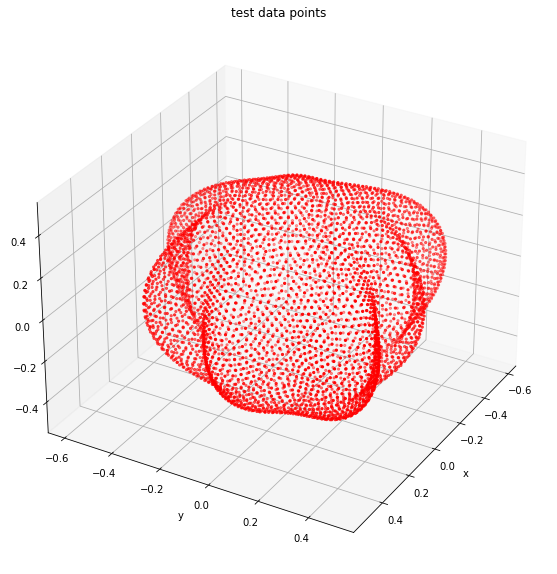

In [18]:
# fixed pseudo random generator
#np.random.seed(777)

# interior test points
sampling = lhs(3, N_tsd_final)
x = ba + dstab*sampling[:,0:1]
y = bc + dstcd*sampling[:,1:2]
z = be + dstef*sampling[:,2:3]
# remove pts out of domain
dst = np.sqrt(x*x+y*y+z*z)
dstid = np.where(dst>=rde)
dst = np.delete(dst, dstid[0], 0)
x   = np.delete(x, dstid[0], 0)
y   = np.delete(y, dstid[0], 0)
z   = np.delete(z, dstid[0], 0)
dstid = np.where(dst<=rdi)
dst = np.delete(dst, dstid[0], 0)
x   = np.delete(x, dstid[0], 0)
y   = np.delete(y, dstid[0], 0)
z   = np.delete(z, dstid[0], 0)
# test pts
qdo, qd = levfun(x, y, z)
Nd_ts_new = len(qdo)
X_tsd = np.hstack( ( x , y , z , qd[:,0:1] ) )

# boundary test points
# inner boundary 
Xbi_ts = np.loadtxt(Xbi_name_tst, dtype='float64')
Nbi_ts = len(Xbi_ts[:,0:1])
# outer boundary 
Xbo_ts = np.loadtxt(Xbo_name_tst, dtype='float64')
Nbo_ts = len(Xbo_ts[:,0:1])
# combine
X_tsb = np.vstack( ( Xbi_ts , Xbo_ts ) )
Nb_ts_new = Nbi_ts + Nbo_ts
qbo, qb = levfun(X_tsb[:,0:1], X_tsb[:,1:2], X_tsb[:,2:3])
X_tsb = np.hstack( ( X_tsb , qb[:,0:1] ) )

# generate interfacial testing points
X_tsg = np.loadtxt(Xg_name_tst, dtype='float64')
Ng_ts_new = len(X_tsg[:,0:1]) 
# qg = np.zeros_like(X_tsg[:,0:1])
# X_tsg = np.hstack( ( X_tsg , qg ) )

# combine all together
phi_ts_final = np.vstack( ( qdo , qbo ) ) #, qg ) )
X_ts_final   = np.vstack( ( X_tsd , X_tsb ) ) #, X_tsg ) )

# exact solution of u
ref_u_ts         = exact_u(X_ts_final[:,0:1], X_ts_final[:,1:2], X_ts_final[:,2:3], phi_ts_final)
ref_u_ts_infnorm = np.linalg.norm(ref_u_ts, np.inf) 
ref_u_ts_L2norm  = np.linalg.norm(ref_u_ts, 2)

# No. of testing points
print(f'No. of interior  test data point: N_tsd_final = {Nd_ts_new}')
print(f'No. of boundary  test data point: N_tsb_final = {Nb_ts_new}')
print(f'No. of interface test data point: N_tsg_final = {Ng_ts_new}')
print(f'No. of overall   test data point: N_ts_total  = {Nd_ts_new+Nb_ts_new+Ng_ts_new}')

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(10,10))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = plt.axes(projection='3d')
#ax.scatter3D(X_tsd[:,0:1], X_tsd[:,1:2], X_tsd[:,2:3], c = "b", marker = ".")
#ax.scatter3D(X_tsb[:,0:1], X_tsb[:,1:2], X_tsb[:,2:3], c = "g", marker = ".")
ax.scatter3D(X_tsg[:,0:1], X_tsg[:,1:2], X_tsg[:,2:3], c = "r", marker = ".")
plt.xlabel('x')
plt.ylabel('y')
ax.view_init(elev=30, azim=30)
plt.title('test data points')

# # tensor style 
X_ts_final = torch.tensor( X_ts_final ).double().to(device)

In [19]:
pred_v = func_model_v(func_params_v, X_ts_final[:,0:3]).detach().cpu().numpy()
qid = np.where(phi_ts_final>=0.)
pred_v[qid] = 0.
pred_w = func_model_w(func_params_w, X_ts_final).detach().cpu().numpy()
pred_u = pred_v + pred_w
abserr = np.abs( pred_u - ref_u_ts )
relerr_inf = np.linalg.norm(abserr, np.inf) / ref_u_ts_infnorm
print(f"L_inf relerr. : {relerr_inf:.4e}")
relerr_L2  = np.linalg.norm(abserr, 2) / ref_u_ts_L2norm
print(f"L_2   relerr. : {relerr_L2:.4e}")    

L_inf relerr. : 4.4148e-06
L_2   relerr. : 1.0713e-06
